In [1]:
import os
import sys
import pandas
from copy import deepcopy
from itertools import product
from tqdm import tqdm
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
from joblib import Parallel, delayed

# %%
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from matplotlib.axes import Axes
from lifelines import CoxPHFitter
from pysurvival.models.survival_forest import RandomSurvivalForestModel

from sklearnex import patch_sklearn
patch_sklearn()
# %%
from bsa.dataset.data_loader import load_raw_data, preprocess_data, splitting_function, drop_unknown_horizon
from bsa.utils.plots import plot_roc_curve
# %%
import random

/home/tonyzou/anaconda3/envs/python-37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from torch.nn import modules
from torch import nn
import torch

from skorch import NeuralNet
import skorch

In [3]:
seed = 3407
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [4]:
from bsa.dataset.data_loader import load_raw_data, preprocess_data
from bsa.scripts.grid_search_survival import load_and_preprocess, get_horizon, get_best_model_cox, predict_cox, predict_rsf
from bsa.scripts.grid_search_deep_survival import get_best_model_dcph, predict_auton, get_best_model_dsm, get_best_model_ddcph
from bsa.scripts.grid_search_binary_classifier import get_training_eval_set, get_best_model_mlp, get_best_model_lr, get_best_model_rf, predict_mlp, predict_sk

Device:  cpu


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
raw_data, raw_label = load_raw_data("/home/tonyzou/bankruptcy-survival-analysis/data/data_for_bankruptcy_prediction_no_lags_corrected.csv")

In [25]:
gvkeys = np.unique(raw_data.index.get_level_values(0).values)

In [30]:
non_binary_groups = raw_data.groupby("gvkey", group_keys=False)

# # Rolling Mean Std
rolling_mean = non_binary_groups.apply(lambda x: x.rolling(window=5, min_periods=1).mean()) # Change to rolling()
rolling_mean = rolling_mean.add_suffix("_rolling_mean")
rolling_std= non_binary_groups.apply(lambda x: x.rolling(window=5, min_periods=1).std()).fillna(0)
rolling_std = rolling_std.add_suffix("_rolling_std")

In [32]:
rolling_mean.loc[1043]

,ActAt_rolling_mean,ActLct_rolling_mean,ActSale_rolling_mean,AltSeqAt_rolling_mean,ApSale_rolling_mean,AtSale_rolling_mean,CfAt_rolling_mean,CfDebt_rolling_mean,CfNw_rolling_mean,CfSale_rolling_mean,...,INaics3_94_rolling_mean,INaics3_95_rolling_mean,INaics3_96_rolling_mean,INaics3_97_rolling_mean,INaics3_98_rolling_mean,INaics3_99_rolling_mean,INaics3_100_rolling_mean,INaics3_101_rolling_mean,INaics3_102_rolling_mean,INaics3_103_rolling_mean
fyear,,,,,,,,,,,,,,,,,,,,,
1980,0.762275,1.595539,0.574971,0.378221,0.094231,0.754284,0.034148,0.133588,0.105501,0.025757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981,0.773786,1.337554,0.616069,0.223014,0.088581,0.795560,-0.022058,-0.144395,-0.045229,-0.024125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.794141,1.653409,0.623409,0.121215,0.080243,0.785146,0.041768,1.673127,0.045259,0.027081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985,0.797427,1.592684,0.576387,0.336294,0.078588,0.723669,0.058185,1.670459,0.087668,0.034794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,0.745875,1.527895,0.619962,0.273170,0.092246,0.873287,0.050256,1.355818,0.111855,0.033292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.683155,1.455990,0.587885,0.165810,0.092982,0.907235,0.052781,1.389700,0.134955,0.036784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.667476,1.522562,0.590280,0.185604,0.094832,0.929184,0.067577,1.470977,0.222592,0.050775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.627874,1.411594,0.554780,0.261623,0.101163,0.920970,0.048999,0.545545,0.223924,0.035947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.583451,1.372405,0.558206,0.065984,0.107462,0.967761,0.020713,0.176786,0.155845,0.019103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
(x_train_raw, outcomes_train), (x_test_raw, outcomes_test), (x_val_raw, outcomes_val) = load_and_preprocess()

In [29]:
outcomes_train.loc[gvkeys[48]]

,IBankrupt,T,E
fyear,,,
1980,0,2,0
1981,0,1,0


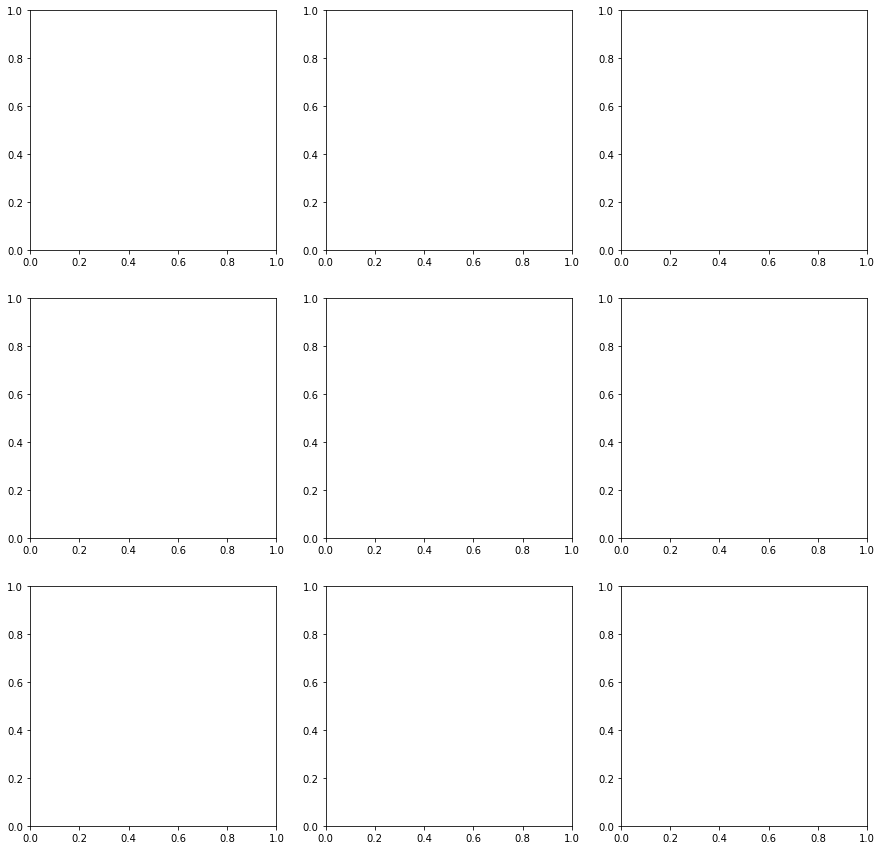

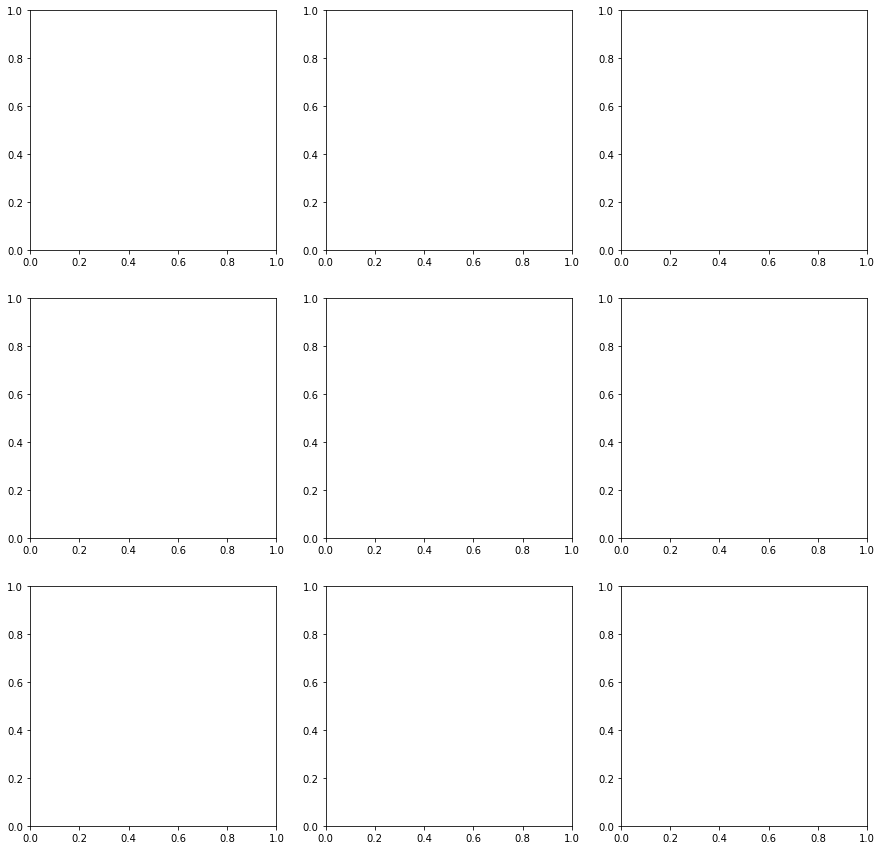

In [6]:
figs, axs = plt.subplots(3, 3, figsize=(15, 15))
figs_log, axs_log = plt.subplots(3, 3, figsize=(15, 15))

In [10]:
lr_best_alphas, rf_best_params, dcph_best_params, cox_best_alphas, dsm_best_params

([0.1, 0.1, 0.0001],
 [(10, 200, 50), (8, 200, 75), (10, 200, 75)],
 [{'layer_size': 64, 'num_layers': 2, 'lr': 0.0001},
  {'layer_size': 128, 'num_layers': 1, 'lr': 0.0001},
  {'layer_size': 128, 'num_layers': 1, 'lr': 0.0001}],
 [0.1, 0.1, 0.1],
 [{'layer_size': 16,
   'num_layers': 2,
   'lr': 0.001,
   'k': 3,
   'temp': 1000,
   'elbo': True},
  {'layer_size': 64,
   'num_layers': 2,
   'lr': 0.001,
   'k': 3,
   'temp': 1,
   'elbo': False},
  {'layer_size': 32,
   'num_layers': 2,
   'lr': 0.001,
   'k': 6,
   'temp': 100,
   'elbo': False}])

In [7]:
LABELS = ["COX", "MLP", "LR", "RF", "DCPH", "DSM"]
mlp_models = [] # 3 models for each horizon
mlp_epochs = []
mlp_best_params = []

# lr_models = []
# lr_best_alphas = []

# rf_models = []
# rf_best_params = []

# dcph_models = []
# dcph_best_params = []

# cox_models = []
# cox_best_alphas = []

# dsm_models = []
# dsm_best_params = []

for i, h in enumerate([1, 2, 5]):
    print("Loading horizon for h={}".format(h))
    (x_train_h, y_train), (x_test_h, y_test), (x_val_h, y_val) = get_horizon(
        x_train_raw, outcomes_train, x_test_raw, outcomes_test, x_val_raw, outcomes_val, h
    )
    
    print("Training MLP...")
    X, Y, cv = get_training_eval_set(x_train_h.values, y_train, x_val_h.values, y_val)
    best_model_mlp, best_epoch_mpl, best_param_mlp = get_best_model_mlp(X, Y, cv)
    mlp_models.append(best_model_mlp)
    mlp_epochs.append(best_epoch_mpl)
    mlp_best_params.append(best_param_mlp)

    # print("Training LR...")
    # best_lr, best_alpha, _ = get_best_model_lr(x_train_h, y_train, x_val_h, y_val)
    # lr_models.append(best_lr)
    # lr_best_alphas.append(best_alpha)

    # print("Training RF...")
    # best_rf, _, best_params_rf = get_best_model_rf(x_train_h, y_train, x_val_h, y_val)
    # rf_models.append(best_rf)
    # rf_best_params.append(best_params_rf)

    # print("Training COX...")
    # best_cox, best_alpha_cox, _ = get_best_model_cox(x_train_raw, outcomes_train, x_val_h, y_val, horizon=h)
    # cox_models.append(best_cox)
    # cox_best_alphas.append(best_alpha_cox)

    # print("Training DCPH...")
    # best_model_dcph, _, best_params_dcph = get_best_model_dcph(x_train_raw, outcomes_train, x_val_raw, outcomes_val, x_val_h, y_val, h)
    # dcph_models.append(best_model_dcph)
    # dcph_best_params.append(best_params_dcph)

    # print("Training DSM...")
    # best_model_dsm, _, best_params_dsm = get_best_model_dsm(x_train_raw, outcomes_train, x_val_raw, outcomes_val, x_val_h, y_val, h)
    # dsm_models.append(best_model_dsm)
    # dsm_best_params.append(best_params_dsm)

Loading horizon for h=1


/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)


Training MLP...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 175 out of 216 | elapsed:  1.0min remaining:   14.6s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:  1.2min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.3min finished


Loading horizon for h=2
Training MLP...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 175 out of 216 | elapsed:   55.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:  1.0min remaining:    6.1s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.1min finished


Loading horizon for h=5
Training MLP...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 175 out of 216 | elapsed:   40.4s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 197 out of 216 | elapsed:   44.6s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   47.8s finished


In [8]:
mlp_epochs, mlp_best_params

([12, 7, 14],
 [{'module__layer_size': 16,
   'module__num_layers': 1,
   'module__dropout_rate': 0.2,
   'module__activation': torch.nn.modules.activation.Tanh,
   'max_epochs': 100,
   'batch_size': 256},
  {'module__layer_size': 32,
   'module__num_layers': 2,
   'module__dropout_rate': 0.2,
   'module__activation': torch.nn.modules.activation.Tanh,
   'max_epochs': 100,
   'batch_size': 256},
  {'module__layer_size': 16,
   'module__num_layers': 2,
   'module__dropout_rate': 0.2,
   'module__activation': torch.nn.modules.activation.LeakyReLU,
   'max_epochs': 100,
   'batch_size': 256}])

/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)
/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)
/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:85: SettingWithCopyWarning: 
A value is trying t

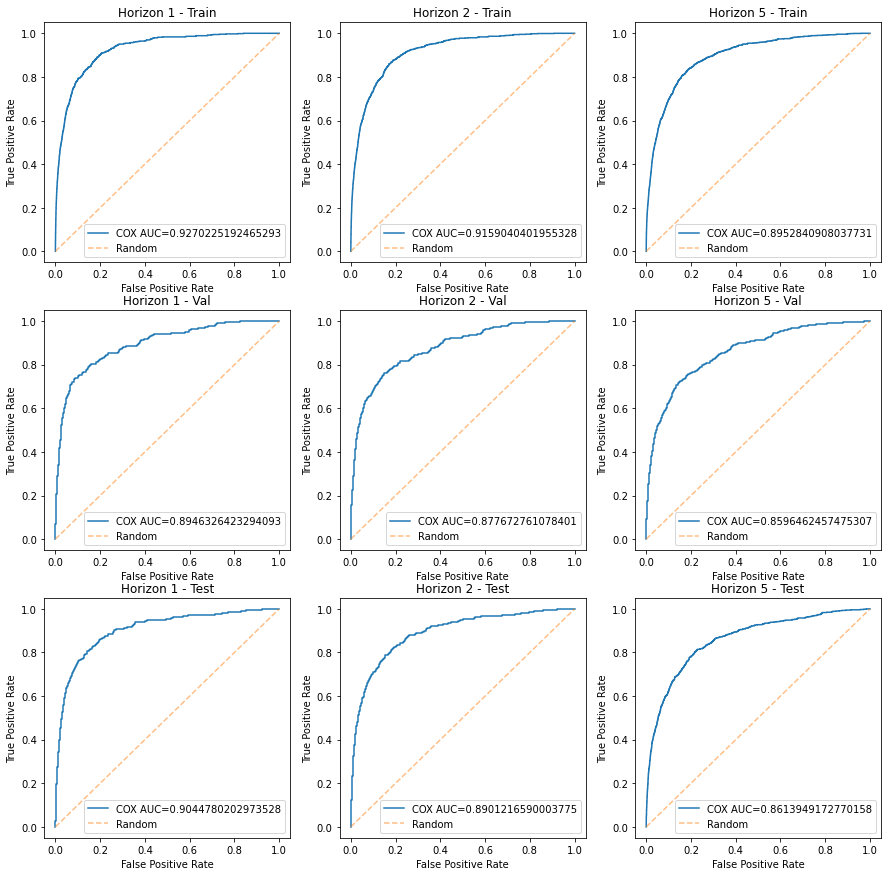

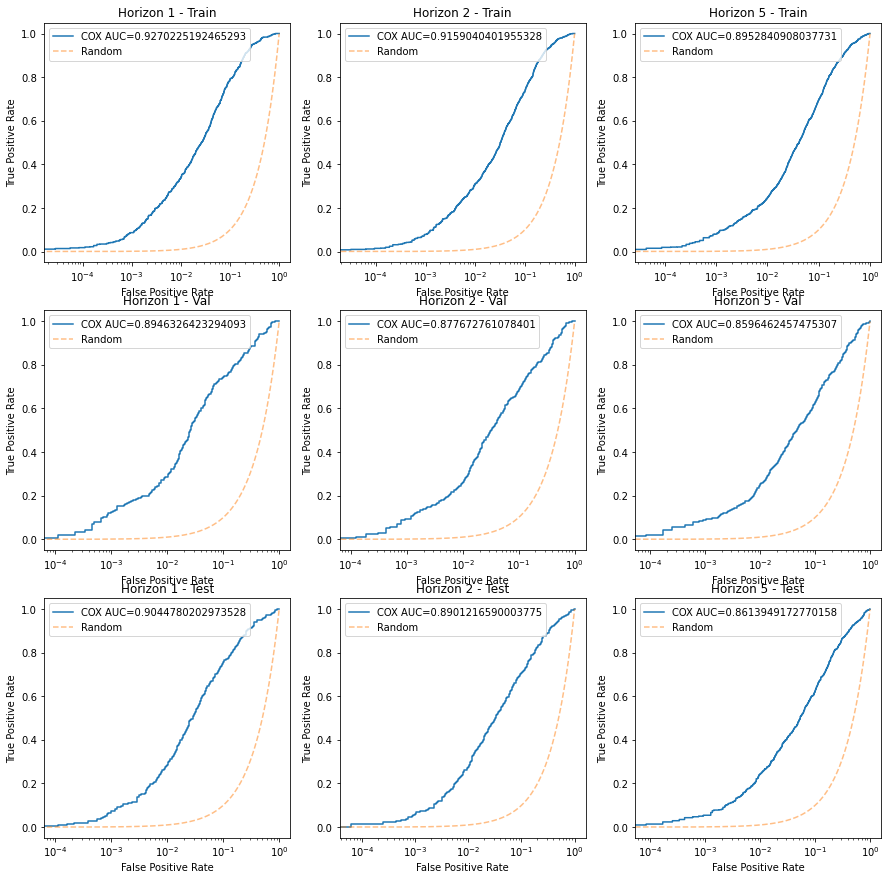

In [ ]:
# LABELS = ["COX", "MLP", "LR", "RF", "DCPH", "DSM", "RSF"]
LABELS = ["COX"]

figs, axs = plt.subplots(3, 3, figsize=(15, 15))
figs_log, axs_log = plt.subplots(3, 3, figsize=(15, 15))

for i, h in enumerate([1, 2, 5]):

    (x_train_h, y_train), (x_test_h, y_test), (x_val_h, y_val) = get_horizon(
        x_train_raw, outcomes_train, x_test_raw, outcomes_test, x_val_raw, outcomes_val, h
    )

    # predict_rsf_train, predict_rsf_val, predict_rsf_test = predict_rsf(rsf_best_models[i], x_train_h, x_val_h, x_test_h, h)
    predict_cox_train, predict_cox_val, predict_cox_test = predict_cox(cox_models[i], x_train_h, x_val_h, x_test_h, h)
    # predict_mlp_train, predict_mlp_val, predict_mlp_test = predict_mlp(mlp_models[i], x_train_h.values, x_val_h.values, x_test_h.values)
    # predict_lr_train, predict_lr_val, predict_lr_test = predict_sk(lr_models[i], x_train_h, x_val_h, x_test_h)
    # predict_rf_train, predict_rf_val, predict_rf_test = predict_sk(rf_models[i], x_train_h, x_val_h, x_test_h)
    # predict_dcph_train, predict_dcph_val, predict_dcph_test = predict_auton(dcph_models[i], x_train_h, x_val_h, x_test_h, h)
    # predict_dsm_train, predict_dsm_val, predict_dsm_test = predict_auton(dsm_models[i], x_train_h, x_val_h, x_test_h, h)

    plot_roc_curve(y_test, [predict_cox_test], LABELS, axs[2, i], title=f"Horizon {h} - Test")
    plot_roc_curve(y_val, [predict_cox_val], LABELS, axs[1, i], title=f"Horizon {h} - Val")
    plot_roc_curve(y_train, [predict_cox_train], LABELS, axs[0, i], title=f"Horizon {h} - Train")

    plot_roc_curve(y_test, [predict_cox_test], LABELS, axs_log[2, i], log=True, title=f"Horizon {h} - Test")
    plot_roc_curve(y_val, [predict_cox_val], LABELS, axs_log[1, i], log=True, title=f"Horizon {h} - Val")
    plot_roc_curve(y_train, [predict_cox_train], LABELS, axs_log[0, i], log=True, title=f"Horizon {h} - Train")

    # plot_roc_curve(y_test, [predict_cox_test, predict_mlp_test, predict_lr_test, predict_rf_test, predict_dcph_test, predict_dsm_test, predict_rsf_test], LABELS, axs[2, i], title=f"Horizon {h} - Test")
    # plot_roc_curve(y_val, [predict_cox_val, predict_mlp_val, predict_lr_val, predict_rf_val, predict_dcph_val, predict_dsm_val, predict_rsf_val], LABELS, axs[1, i], title=f"Horizon {h} - Val")
    # plot_roc_curve(y_train, [predict_cox_train, predict_mlp_train, predict_lr_train, predict_rf_train, predict_dcph_train, predict_dsm_train, predict_rsf_train], LABELS, axs[0, i], title=f"Horizon {h} - Train")

    # plot_roc_curve(y_test, [predict_cox_test, predict_mlp_test, predict_lr_test, predict_rf_test, predict_dcph_test, predict_dsm_test, predict_rsf_test], LABELS, axs_log[2, i], log=True, title=f"Horizon {h} - Test")
    # plot_roc_curve(y_val, [predict_cox_val, predict_mlp_val, predict_lr_val, predict_rf_val, predict_dcph_val, predict_dsm_val, predict_rsf_val], LABELS, axs_log[1, i], log=True, title=f"Horizon {h} - Val")
    # plot_roc_curve(y_train, [predict_cox_train, predict_mlp_train, predict_lr_train, predict_rf_train, predict_dcph_train, predict_dsm_train, predict_rsf_train], LABELS, axs_log[0, i], log=True, title=f"Horizon {h} - Train")

In [ ]:
figs.show()

In [ ]:
figs.savefig("roc_curve.png")

In [ ]:
figs_log.savefig("roc_curve_log.png")

In [5]:
import pickle

datas = (x_train_raw, outcomes_train, x_test_raw, outcomes_test, x_val_raw, outcomes_val)
checkpoint = (datas, rsf_best_models, mlp_models, lr_models, lr_best_alphas, rf_models, rf_best_params, dcph_models, dcph_best_params, cox_models, cox_best_alphas, dsm_models, dsm_best_params)

pickle.dump(checkpoint, open("checkpoint.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'x_train_raw' is not defined

In [6]:
import pickle
(x_train_raw, outcomes_train, x_test_raw, outcomes_test, x_val_raw, outcomes_val), rsf_best_models, mlp_models, lr_models, lr_best_alphas, rf_models, rf_best_params, dcph_models, dcph_best_params, cox_models, cox_best_alphas, dsm_models, dsm_best_params = pickle.load(open("checkpoint.pkl", "rb"))

# Train RF

In [18]:
rf_models = []
rf_best_params = []

for i, h in enumerate([1, 2, 5]):

    (x_train_h, y_train), (x_test_h, y_test), (x_val_h, y_val) = get_horizon(
        x_train_raw, outcomes_train, x_test_raw, outcomes_test, x_val_raw, outcomes_val, h
    )

    best_rf, _, best_params_rf = get_best_model_rf(x_train_h, y_train, x_val_h, y_val)
    rf_models.append(best_rf)
    rf_best_params.append(best_params_rf)

/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)


loss: 0.05654575392153701
loss: 0.05613885444353027
loss: 0.05597989946716225
loss: 0.0559622359647077
loss: 0.05587127681183613
loss: 0.0558593081829817
loss: 0.05577984706442849
loss: 0.05574749927797512
loss: 0.05571416374911546
loss: 0.055634364199714986
loss: 0.05563411742232788


/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)


loss: 0.08287766255054543
loss: 0.08261569561536626
loss: 0.0823852196595024
loss: 0.08234012829422255
loss: 0.08232186728324817
loss: 0.08230492731953415
loss: 0.08215086196333683
loss: 0.08169477893887916
loss: 0.08155196855873705
loss: 0.0813998010833941
loss: 0.08132639293451764
loss: 0.08119562589784857
loss: 0.0810670446716786


/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)


loss: 0.1510433249387486
loss: 0.1507435148214615
loss: 0.1506320365945244
loss: 0.1497435602417819
loss: 0.1496521711767267
loss: 0.14961054901416404
loss: 0.14944710353936916
loss: 0.1489647805806867
loss: 0.14889214479142499
loss: 0.14882890680266952
loss: 0.1487714191798297
loss: 0.14815113682583864
loss: 0.14784670206170533
loss: 0.14781304367786743
loss: 0.14707122821301066
loss: 0.14699718339646747
loss: 0.14689904482313348
loss: 0.1466266157021066
loss: 0.14610145573517835
loss: 0.14596643073415577


## Find best RSF for all horizons

In [5]:
rsf_all_models = os.listdir("/home/tonyzou/bankruptcy-survival-analysis/bsa/experiments/rsf-all")
rsf_all_models = [os.path.join("/home/tonyzou/bankruptcy-survival-analysis/bsa/experiments/rsf-all/", model_name) for model_name in rsf_all_models]
rsf_best_models = []

In [8]:
for i, h in enumerate([1, 2, 5]):

    (x_train_h, y_train), (x_test_h, y_test), (x_val_h, y_val) = get_horizon(
        x_train_raw, outcomes_train, x_test_raw, outcomes_test, x_val_raw, outcomes_val, h
    )

    losses = []

    def try_model(model):
        _, predict_rsf_val, _ = predict_rsf(model, x_train_h, x_val_h, x_test_h, h)
        
        return model, log_loss(y_val, predict_rsf_val)
    
    res = Parallel(n_jobs=8, verbose=1)(delayed(try_model)(model) for model in rsf_all_models)
    res = sorted(res, key=lambda x: x[1])

    rsf_best_models.append(res[0][0])

/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  1.1min finished


In [9]:
rsf_best_models

['/home/tonyzou/bankruptcy-survival-analysis/bsa/experiments/rsf-all/rsf-1-10-100-50.zip',
 '/home/tonyzou/bankruptcy-survival-analysis/bsa/experiments/rsf-all/rsf-1-10-200-50.zip',
 '/home/tonyzou/bankruptcy-survival-analysis/bsa/experiments/rsf-all/rsf-1-10-200-50.zip']